<a href="https://colab.research.google.com/github/smha-Promedius/vit_lecture/blob/master/notebook/00_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such 

## 라이브러리 & 커맨드 준비

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1
w = !apt install tree
print(w[-2])

Use 'apt autoremove' to remove it.


* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [ ]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## 초기설정

In [ ]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## GPU 디바이스 사용 여부 확인

- Colab 무료 계정에서 GPU의 사용량은 한정되어 있습니다. 시간이 오래 걸리는 학습이 아니면 기본적으로 cpu를 사용하는 것을 권장합니다. 본 강의에서는 **02_vit_train.ipynb**에서만 GPU를 사용할 예정입니다.

- 아래와 같은 코드로 어떤 device가 할당 되었는지 확인 가능하며, 이 후, 모델이나 데이터는 device 변수를 직접 사용해서 할당하는 것이 좋습니다. 만약, 설정을 바꾸고 싶으시면 **런타임** -> **런타임 유형 바꾸기**에서 원하는 디바이스를 선택하시기 바랍니다.

In [ ]:
# GPU 디바이스 할당 확인

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 강의용 공통함수 가져오기

- 강의에 사용할 공통함수는 별도의 깃헙 레포지토리를 사용하고 있습니다. 해당 깃헙 레포지토리를 클론한 다음, 아래와 같이 import합니다.

- 사용할 함수의 구체적인 내용과 역할은 마지막에 설명 할 예정입니다.

In [ ]:
# 공통함수 다운로드
!git clone https://github.com/smha-Promedius/pythonlibs.git

# 공통함수 임포트
from pythonlibs.torch_lib1 import *

# 공통함수 체크
print(README)

Cloning into 'pythonlibs'...
remote: Enumerating objects: 52, done.
remote: Total 52 (delta 0), reused 0 (delta 0), pack-reused 52
Unpacking objects: 100% (52/52), done.
Common Library for PyTorch
Author: M. Akaishi
Translator: Seungmin Ha


## 학습 데이터 읽어오기

- 별도의 레포지토리에는 공통함수 이 외에도, 이번 과정에서 사용하게 될 학습/평가/검증용 데이터셋이 적당량 포함되어 있습니다.

- 데이터셋은 학습/평가/검증 용도에 따라 & 클래스1(colon)/클래스2(lung) 폴더를 구분해서 압축파일로 제공됩니다. 아래 코드를 사용해서 압축을 해제하면 모두 720장의 이미지를 얻게 됩니다.

In [ ]:
# 학습용 이미지 다운로드
w = !wget https://github.com/smha-Promedius/pythonlibs/raw/master/images_vit/colon_vs_lung.zip
print(w[-2])

# 학습용 이미지 압축풀기
w = !unzip colon_vs_lung.zip
print(w[-1])
# 디렉토리명 설정
data_dir = 'colon_vs_lung'

# 학습, 테스트 디렉토리명 설정
import os
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# 분류 클래스 설정
classes = ['colon', 'lung']

# 압축해제 결과 트리 구조 보기
!tree colon_vs_lung

2022-11-14 07:29:53 (159 MB/s) - ‘colon_vs_lung.zip.1’ saved [56240314/56240314]
replace colon_vs_lung/test/colon/colonca1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
colon_vs_lung
├── test
│   ├── colon
│   │   ├── colonca10.jpeg
│   │   ├── colonca11.jpeg
│   │   ├── colonca12.jpeg
│   │   ├── colonca13.jpeg
│   │   ├── colonca14.jpeg
│   │   ├── colonca15.jpeg
│   │   ├── colonca16.jpeg
│   │   ├── colonca17.jpeg
│   │   ├── colonca18.jpeg
│   │   ├── colonca19.jpeg
│   │   ├── colonca1.jpeg
│   │   ├── colonca20.jpeg
│   │   ├── colonca21.jpeg
│   │   ├── colonca22.jpeg
│   │   ├── colonca23.jpeg
│   │   ├── colonca24.jpeg
│   │   ├── colonca25.jpeg
│   │   ├── colonca26.jpeg
│   │   ├── colonca27.jpeg
│   │   ├── colonca28.jpeg
│   │   ├── colonca29.jpeg
│   │   ├── colonca2.jpeg
│   │   ├── colonca30.jpeg
│   │   ├── colonca3.jpeg
│   │   ├── colonca4.jpeg
│   │   ├── colonca5.jpeg
│   │   ├── colonca6.jpeg
│   │   ├── colonca7.jpeg
│   │   ├── colonca8.jpeg
│   │   ├── colonca

## 데이터셋 객체, 데이터로더 구성하기


In [ ]:
# transform 의 정의
# 검증 데이터용: 정규화만을 실시
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 학습 데이터용: 정규화에 RandomHorizontalFlip 과 RandomErasing 을 추가로 실시
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])


# dataset 정의
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
train_data2 = datasets.ImageFolder(train_dir, transform=test_transform)

valid_data = datasets.ImageFolder(valid_dir, transform=test_transform)

test_data = datasets.ImageFolder(test_dir, transform=test_transform)


# dataloader 정의
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=True)

valid_loader = DataLoader(valid_data, batch_size=5, shuffle=False)
valid_loader2 = DataLoader(valid_data, batch_size=10, shuffle=True)

test_loader = DataLoader(test_data, batch_size=5, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=True)

## 학습 이미지 데이터 확인

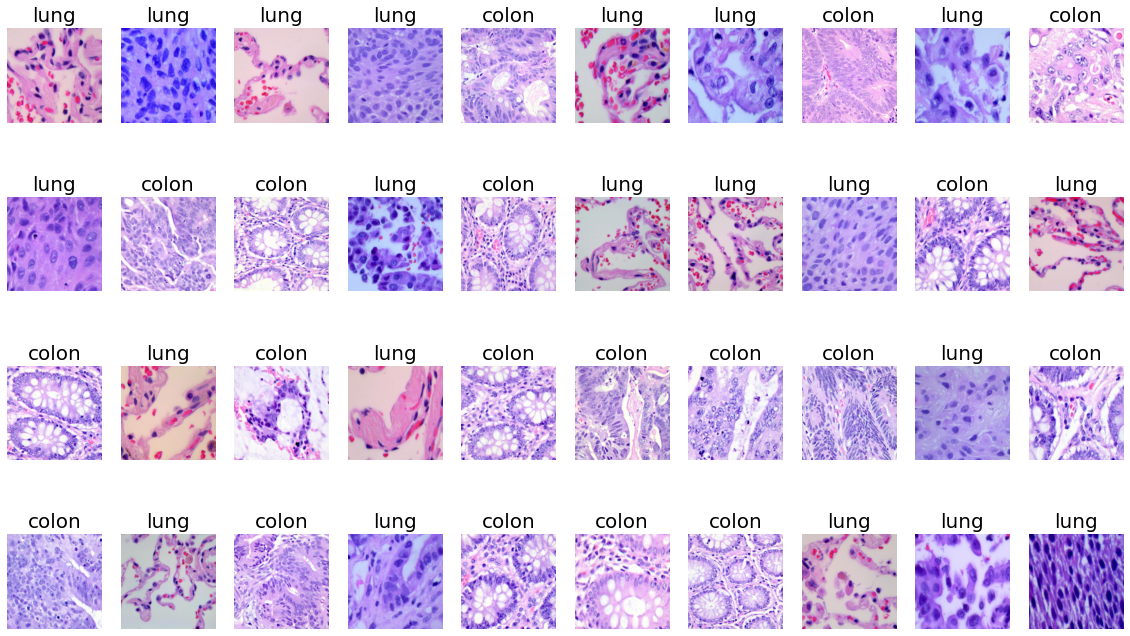

In [ ]:
# 학습용 데이터 (４0건)
show_images_labels(train_loader2, classes, None, None)

## 검증 이미지 데이터 확인

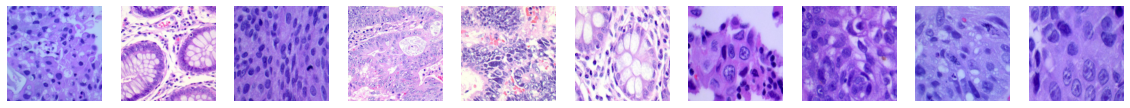

In [ ]:
# 검증용 데이터 (10건)
# 우선 정답 라벨 없이 이미지만을 표시합니다.
# 각 사진이 개와 늑대중 어떤 것인지 각자 판단해 보기 바랍니다.
torch_seed()
show_images_labels(test_loader2, ['', ''], None, None)

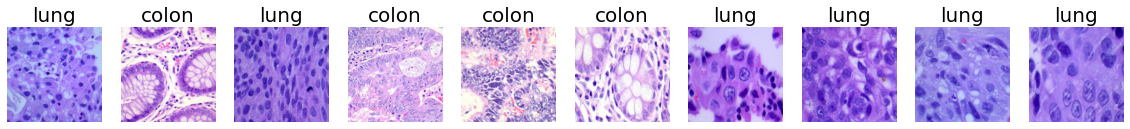

In [ ]:
# 검증용 데이터 (10건)
# 이것이 정답 데이터 입니다.
# 10건 중 몇 건의 정답을 맞췄습니까.
torch_seed()
show_images_labels(test_loader2, classes, None, None)

## (참고) 공통함수의 내부 구조

In [ ]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
    
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 학습 페이즈
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 그라디언트 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 그라이언트 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답을 맞춘 수 산출
            train_acc += (predicted == labels).sum()

            # 평균 손실값과 정확도 계산
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        # 예측 페이즈
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답을 맞춘 수 산출
            val_acc += (predicted == labels).sum()

            # 평균 손실값과 정확도 계산
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [ ]:
# 이미지와 라벨 표시
def show_images_labels(loader, classes, net, device):

    # 데이터로더에서 최초 한 세트의 이미지와 라벨을 취득
    for images, labels in loader:
        break
    # 표시 수는 숫자 50과 배치사이즈를 비교해 작은 쪽을 선택
    n_size = min(len(images), 50)

    if net is not None:
        # 디바이스에 데이터 할당
        inputs = images.to(device)
        labels = labels.to(device)

        # 예측 계산
        outputs = net(inputs)
        predicted = torch.max(outputs,1)[1]
        #images = images.to('cpu')

    # 최초 n_size 만큼 표시
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # net 이 None 이 아니면 예측 결과도 타이틀에 표기
        if net is not None:
            predicted_name = classes[predicted[i]]
            # 정답 여부를 색으로 나눔
            if label_name == predicted_name:
                c = 'k'
            else:
                c = 'b'
            ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # net 가 None 일 경우는 정답 라벨만을 표시
        else:
            ax.set_title(label_name, fontsize=20)
        # 텐서를 넘파이로 변환
        image_np = images[i].numpy().copy()
        # 축의 순서 변경 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 값의 범위를 [-1, 1] -> [0, 1] 로 되돌리기
        img = (img + 1)/2
        # 결과 표시
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [ ]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True